In [1]:
%matplotlib inline
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dummy import *

plt.style.use('ggplot')
import psycopg2

con = psycopg2.connect("dbname=test1")

In [2]:
# subs = generate_submissions(users=10, pbls=100)
course_id = "C00152"

userslist = pd.read_sql_query("select user_id from coursesusers where course_id like '%s';" % course_id,con=con)
userslist = [u[0] for u in userslist.values if u[0]]
usersstr = str(userslist).strip('[]')

users = pd.read_sql_query("select user_id, creation_date from users \
                            where demo=0 and instructor=0 and administrator=0\
                            and user_id in (%s);" % usersstr,con=con)

lusers = users.user_id.tolist()
usersstr = str(lusers).strip('[]')

problists = pd.read_sql_query("select list_id from courseslists where course_id like '%s';" % course_id ,con=con)
problists = [l[0] for l in problists.values if l[0]]
problistsstr = str(problists).strip('[]')

probs = pd.read_sql_query("select problem_nm from listitems where list_id \
                                in(%s);" % problistsstr,con=con)

lprobs = [p[0] for p in probs.values if p[0]]
lprobsstr = str(lprobs).strip('[]')

submissions = pd.read_sql_query("select submission_uid, user_id, problem_id, submission_id, \
                        state, time_out, time_in, veredict, score \
                        from submissions where user_id in (%s);" % (usersstr) ,
                       con=con)

submissions.problem_id = submissions.problem_id.apply(lambda x: x[:-3])
submissions.set_index('submission_uid', inplace=True)

subs = submissions[submissions.problem_id.isin(lprobs)]

goodSubs = submissions[submissions.veredict == 'AC']
badSubs = submissions[submissions.veredict != 'AC']

In [3]:
bm = bianary_mat(subs)

In [4]:
def fct(row):
    '''
    u is the a binary verctor
    ''' 
    bads = subs[(subs.veredict != 'AC') & 
                       (subs.problem_id == row[0])].problem_id.count()
    tots = subs[subs.problem_id == row[0]].problem_id.count()
    return (float(bads) / tots)

In [5]:
Difficilties = evaluate_difficuly(bm, name='diff1')
Difficilties = Difficilties.join(evaluate_difficuly(bm, fct, name="diff2"))

In [6]:
# Difficilties

<IPython.core.display.Javascript object>


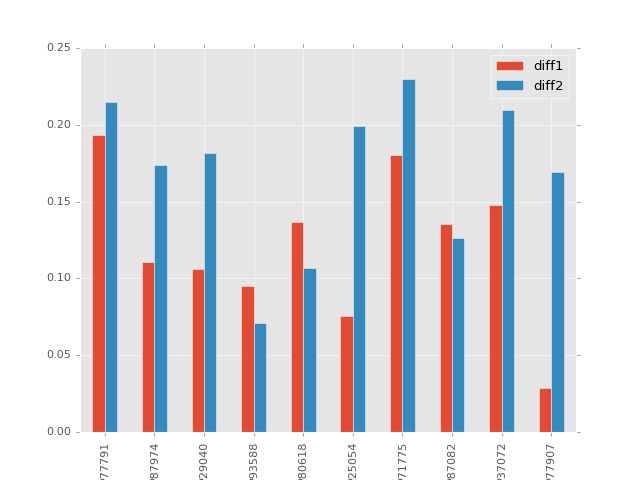

In [7]:
Difficilties.head(n=10).plot(kind='bar')

<IPython.core.display.Javascript object>


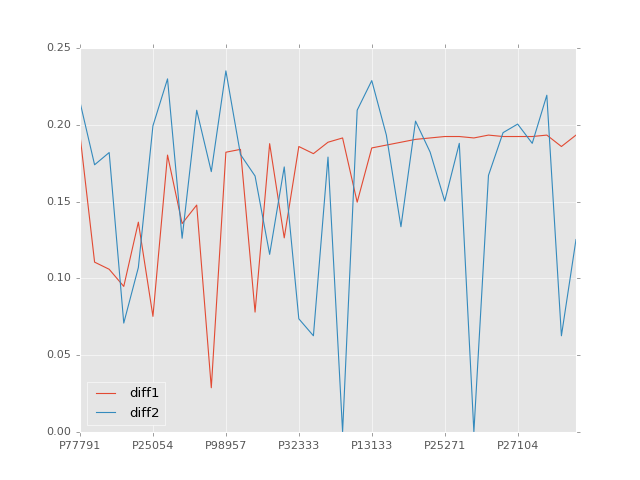

In [20]:
Difficilties.head(n=50).plot()

In [9]:
def Abilities(mat, pblslev):
    df = mat.join(pblslev)
    #print df
    return [df[df[i] > 0 ][pblslev.name].sum() for i in bm]

In [10]:
usrAb = Abilities(bm, Difficilties.diff1)
normalize(usrAb)
usrAb = pd.DataFrame(usrAb, index=bm.columns, columns=['abl1']).T

In [11]:
usrAb2 = Abilities(bm, Difficilties.diff2)
normalize(usrAb2)
usrAb2 = pd.DataFrame(usrAb2, index=bm.columns, columns=['abl2']).T
usrAb = usrAb.append(usrAb2)

<IPython.core.display.Javascript object>


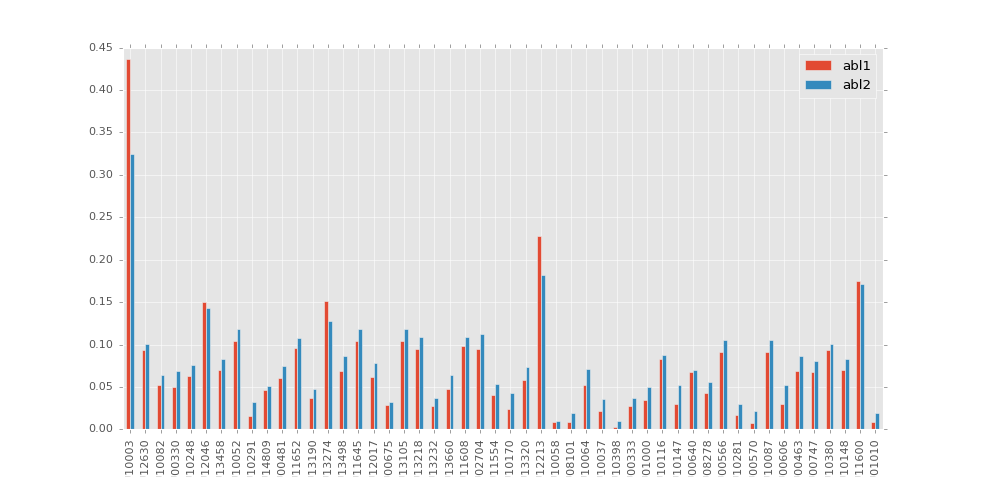

In [17]:
usrAb.T.head(n=50).plot(kind='bar')

In [19]:
usrAb.T.count()

abl1    209
abl2    209
dtype: int64